# Packages

In [164]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm

import contextlib
from src.preprocessing import apply_transformation

# 1. Data

## FRED dataset

In [128]:
fred_md = pd.read_csv("data/fred_md_2024_12.csv")
fred_md_short = (
    fred_md.iloc[1:]
    .assign(sasdate=pd.to_datetime(fred_md.iloc[1:].sasdate, format="%m/%d/%Y"))
    .set_index("sasdate")
)
fred_info = pd.read_csv("data/FRED_MD_updated_appendix.csv", encoding="latin1")

start_date, end_date = "1960", "2024"

for _, row in fred_info.iterrows():
    series_name = row['fred']
    transformation_code = row['tcode']

    # Apply appropriate transformation to fred df
    with contextlib.suppress(Exception):
        fred_md_short[series_name] = apply_transformation(fred_md_short[series_name], transformation_code)

fred_md_short = fred_md_short[
    (fred_md_short.index >= start_date) & (fred_md_short.index <= end_date)
].dropna(axis=1)

## Recession data

In [129]:
us_rec = pd.read_csv("data/USREC.csv")
us_rec = us_rec.assign(
    observation_date=pd.to_datetime(us_rec.observation_date)
    ).set_index("observation_date")
us_rec = us_rec.loc[fred_md_short.index,:]

In [130]:
common_dates = fred_md_short.index.intersection(us_rec.index)
X = fred_md_short.loc[common_dates]
y = us_rec.loc[common_dates]

## Standardization

In [131]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Variable Selection

In [149]:
X_lagged = fred_md_short.shift(1).dropna()
common_index = X_lagged.index.intersection(us_rec.index)
X_lagged = X_lagged.loc[common_index]
y_aligned = us_rec.loc[common_index]
correlations_lagged = X_lagged.corrwith(y_aligned.squeeze())
top_lagged_features = correlations_lagged.abs().sort_values(ascending=False).head(10)  # Show top 30

X_selected = X_lagged.loc[:,X_lagged.columns.isin(top_lagged_features.index)]
X_selected = sm.add_constant(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_aligned, test_size = 0.2, random_state=42)

# Model

In [150]:
# X_train = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train).fit()
logit_model.params

Optimization terminated successfully.
         Current function value: 0.222066
         Iterations 9


const             45.197782
INDPRO           -63.181843
IPDMAT           -10.424617
CUMFNS             0.060553
USGOOD            54.678061
MANEMP           -22.133434
DMANEMP         -110.419309
CES0600000007     -0.532487
AWHMAN            -0.667876
TB3SMFFM          -2.710025
TB6SMFFM           1.468580
dtype: float64

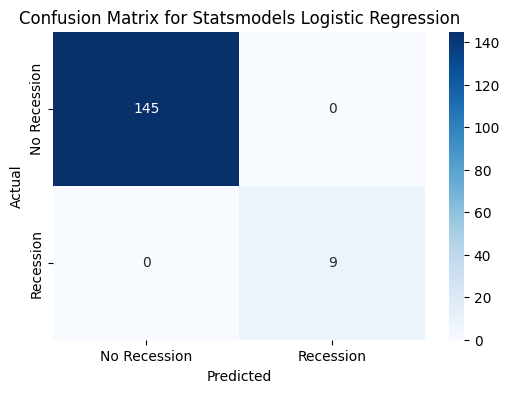

In [163]:
y_pred_prob = logit_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Recession", "Recession"], yticklabels=["No Recession", "Recession"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Statsmodels Logistic Regression")
plt.show()

In [167]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

# Results